# Brief Intro to ICA

#### References:
- Aapo Hyvarinen's four chapter excerpts provided in your class resources
- Or more generally Aapo Hyvarinen's <a href="https://www.cs.helsinki.fi/u/ahyvarin/papers/bookfinal_ICA.pdf"> Independent Component Analysis</a> book
- Most of the code below follows the <a href="http://scikit-learn.org/stable/auto_examples/decomposition/plot_ica_blind_source_separation.html#sphx-glr-auto-examples-decomposition-plot-ica-blind-source-separation-py"> Blind source separation using FastICA </a> scikit-learn example


# Setup

Suppose:
- we observe an $n$-dimensional random variable ${\bf x}_t=(x_1(t),...,x_n(t))\in{R}^n$:
- we want to find a set of $n$ maximally independent signals ${\bf s}_t=(s_1(t),...,s_n(t))\in{R}^n$ whose mixture approximates ${\bf x}$:
$$
{\bf x}_t = {\bf A s}_t+\varepsilon_t,\quad t=1,...,T
$$
- if in fact ${\bf x}$ can be written as a linear combination of $n$ independent components, then the noise term will be zero 
- Finally, suppose without loss of generality
$$
E[{\bf x}{\bf x}^T]=I, \quad E[{\bf x}]=0
$$
    - where expectation is taken with respect to the empirical measure for observations at $t=1,...,T$
- The above assumption can easily be achieved if we demean ${\bf x}$ and transform into the PCA basis ${\bf x}\rightarrow{z}\equiv{D}^{-1/2}{\bf Vx}$, where the original signal has the SVD decomposition ${\bf x} = {\bf UDV^T}$
    - Note that without loss of generality we can also let $E[{\bf s}]=0$ and $E[s^2_i]=0$ 

# Unsolvable Case: ${\bf s}(t)$ is Gaussian 

In this case it is easy to see that we cannot solve the problem. In fact if ${\bf R}$ is any orthogonormal transformation then:
$$
{\bf x}\sim{\bf A s} = {\bf A R^T R s}\equiv {\bf \tilde{A} \tilde{s}}
$$
so there are infinitely many solutions to our problem. Let's assume $\varepsilon=0$ for now. Equivalently, we the Gaussian signal case has no unique solution:
- Because ${\bf x}$ is Gaussian being a superposition of gaussians
- And because an orthonormal transformation of the signal preserves the covariance $E[{\bf x x^T}]$.
- Note that unlike most statistics problems, the Gaussian case here is not the easiest to solve!

# Suppose $s$ is not Gaussian

Then it is easy to see that a linear combination of $s_i$ and $s_j$ is more Gaussian than any of the two components!
- To see this, consider the Kurtosis for a uni-variate variable:
$$ 
\text{kurt}(y) = E[y^4]-3E[y^2]^2=E[y^4]-3
$$
    - For Gaussian distribution, the kurtosis is $0$
    - Sub-(super-) Gaussian distributions have kurtosis less (bigger) than $0$.
- Then for $s_1$ and $s_2$ independent we have:
$$
\begin{align}
\text{kurt}(\alpha s_i) & = \alpha^4\text{kurt}(s_i)
\text{kurt}(s_1 + s_2) & = \text{kurt}(s_1) + \text{kurt}(s_2)\\
\end{align}
$$
- Therefore
$$
\begin{align}
\text{kurt}({\bf q^Ts})&=q^4_1\text{kurt}(s_1) + q^4_2\text{kurt}(s_2)\\
\end{align}
$$

One can show that as long as the kurtoses of each $s_i$ are non-zero, the maximum of $F({\bf q})\equiv|\text{kurt}({\bf q^Ts})|$ is achieved when ${\bf q^Ts}$ equals either $s_1$ or $s_2$:
- if $\text{kurt}(s_i)=1$ this amounts to minimizing $q^4_1 + q^4_2$, which is achieved for $q_i=\pm{1}$.
- **This means that the kurtosis of a sum of any two non-Gaussian variables has a kurtosis less than each of them!**
- **In essense this is similar to the Central Limit Theorem argument**
    - except the CLT holds in the $n\rightarrow\infty$ limit even if the kurtosis of each variable is infinite. In the $n\rightarrow\infty$ limit it turns out one only needs finite variance of each variable in the sum.

** Since the kurtosis of the sum of $n$ non-Gaussian variables is less than the kurtosis of each of them:**
- Then we just need to find the $n-$lowest minima of $F({\bf q})=|\text{kurt}({\bf q^T s})|$ at ${\bf q}_1,...,{\bf q}_n$. Then ${\bf Qx}={\bf s}$ or ${\bf A}={\bf Q}^{-1},\quad{\bf Q}=({\bf q}_1,..,{\bf q}_n)$ 
- Note that the only distributional dependence here is that ${\bf s}$ is non-Gaussian!


# In General, We Just Need to Maximize the Non-Gaussianity of $F({\bf q})$

- Maximizing kurtosis is one way:
    - can do it with gradient descent methods 
    - But Kurtosis is very sensitive to outliers
    - and gradient descent algorithms are slow near local minima
- Faster and better algorithms exist
    - which involve adaptive (Newton-step) fixed point methods
    - Or optimizing distribution-free entropic measures of Non-Gaussianity
        - Turns out for a *fixed covariance* of a set of random variables ${\bf x}$, the entropy is largest when the variables are Gaussian.
        - Intuitively, Gaussian random variables are least informative.
        - So we can find the transformation ${\bf Q}$ such that the entropy of ${\bf Q x}$ is minimal.
- But the intuition remains the same
    - E.g. optimize for non-Gaussianity

# Scikit-Learn's <a href="http://scikit-learn.org/stable/auto_examples/decomposition/plot_ica_blind_source_separation.html#sphx-glr-auto-examples-decomposition-plot-ica-blind-source-separation-py"> Demo of FastICA</a>

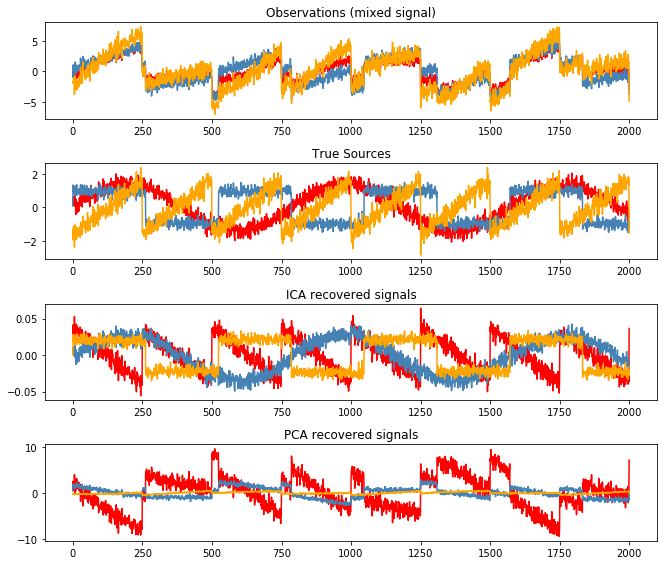

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

from sklearn.decomposition import FastICA, PCA

# #############################################################################
# Generate sample data
np.random.seed(0)
n_samples = 2000
time = np.linspace(0, 8, n_samples)

s1 = np.sin(2 * time)  # Signal 1 : sinusoidal signal
s2 = np.sign(np.sin(3 * time))  # Signal 2 : square signal
s3 = signal.sawtooth(2 * np.pi * time)  # Signal 3: saw tooth signal

S = np.c_[s1, s2, s3]
S += 0.2 * np.random.normal(size=S.shape)  # Add noise

S /= S.std(axis=0)  # Standardize data
# Mix data
A = np.array([[1, 1, 1], [0.5, 2, 1.0], [1.5, 1.0, 2.0]])  # Mixing matrix
X = np.dot(S, A.T)  # Generate observations

# Compute ICA
ica = FastICA(n_components=3)
S_ = ica.fit_transform(X)  # Reconstruct signals
A_ = ica.mixing_  # Get estimated mixing matrix

# We can `prove` that the ICA model applies by reverting the unmixing.
assert np.allclose(X, np.dot(S_, A_.T) + ica.mean_)

# For comparison, compute PCA
pca = PCA(n_components=3)
H = pca.fit_transform(X)  # Reconstruct signals based on orthogonal components

# #############################################################################
# Plot results

plt.figure(figsize=(10,8))

models = [X, S, S_, H]
names = ['Observations (mixed signal)',
         'True Sources',
         'ICA recovered signals',
         'PCA recovered signals']
colors = ['red', 'steelblue', 'orange']

for ii, (model, name) in enumerate(zip(models, names), 1):
    plt.subplot(4, 1, ii)
    plt.title(name)
    for sig, color in zip(model.T, colors):
        plt.plot(sig, color=color)

plt.subplots_adjust(0.09, 0.04, 0.94, 0.94, 0.26, 0.46)
plt.show()